In [4]:
import pandas as pd 

In [5]:
df = pd.read_csv("raw_data.csv", low_memory=False , compression = 'gzip')

In [7]:
df.head()

,ts,number,pick_lat,pick_lng,drop_lat,drop_lng
0,2020-03-26 07:07:17,14626,12.313621,76.658195,12.287301,76.602280
1,2020-03-26 07:32:27,85490,12.943947,77.560745,12.954014,77.543770
2,2020-03-26 07:36:44,05408,12.899603,77.587300,12.934780,77.569950
3,2020-03-26 07:38:00,58940,12.918229,77.607544,12.968971,77.636375
4,2020-03-26 07:39:29,05408,12.899490,77.587270,12.934780,77.569950


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8381556 entries, 0 to 8381555
Data columns (total 6 columns):
 #   Column    Dtype  
---  ------    -----  
 0   ts        object 
 1   number    object 
 2   pick_lat  float64
 3   pick_lng  float64
 4   drop_lat  float64
 5   drop_lng  float64
dtypes: float64(4), object(2)
memory usage: 383.7+ MB


In [9]:
df['ts']= pd.to_datetime(df['ts'])

In [14]:
df['number'] = df['number'].astype(str).str.strip()

In [16]:
df['number'] = pd.to_numeric(df['number'], errors='coerce')

In [17]:
df['number'] = df['number'].astype('Int64')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8381556 entries, 0 to 8381555
Data columns (total 6 columns):
 #   Column    Dtype         
---  ------    -----         
 0   ts        datetime64[ns]
 1   number    Int64         
 2   pick_lat  float64       
 3   pick_lng  float64       
 4   drop_lat  float64       
 5   drop_lng  float64       
dtypes: Int64(1), datetime64[ns](1), float64(4)
memory usage: 391.7 MB


In [19]:
df.isnull().sum()

ts            0
number      121
pick_lat      0
pick_lng      0
drop_lat      0
drop_lng      0
dtype: int64

In [22]:
df = df.dropna(subset=['number'])
df['number'] = df['number'].astype(int)

In [23]:
df.isnull().sum()

ts          0
number      0
pick_lat    0
pick_lng    0
drop_lat    0
drop_lng    0
dtype: int64

In [ ]:
Nous allons observer graphiquement les distributions , les valeurs aberrantes et les correlations des differentes variables 

In [26]:
# Boxplot 

numericals_cols = df.select_dtypes(include=['int64','float64']).columns
categoricals_cols = df.select_dtypes(include=['object','category','bool']).columns


<Figure size 1600x800 with 0 Axes>

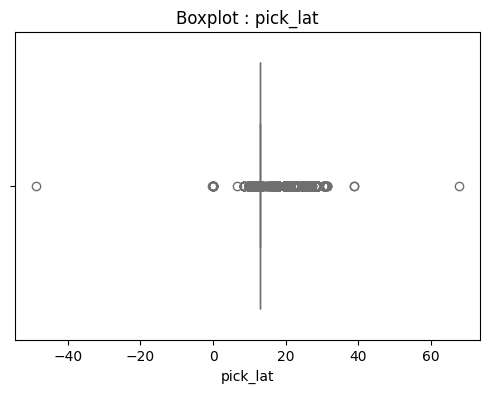

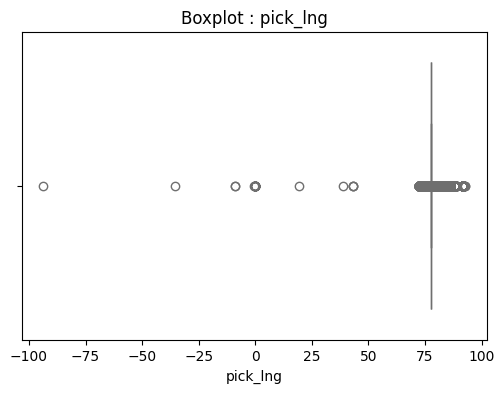

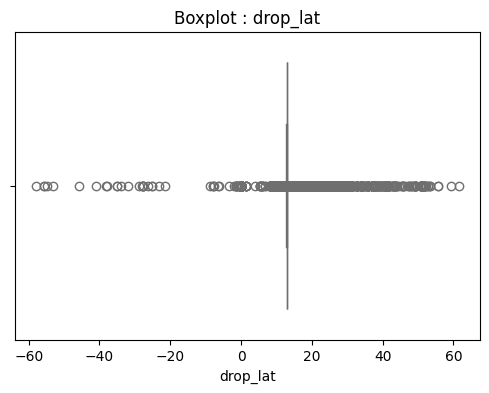

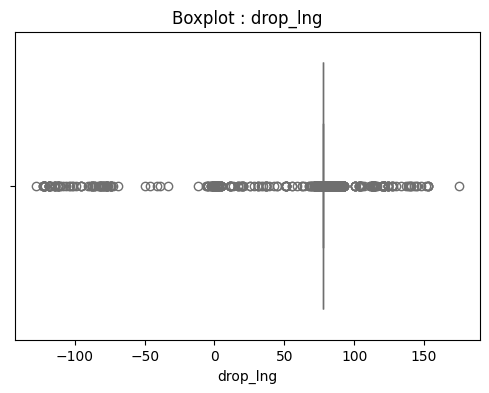

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt 

plt.figure(figsize=(16,8))

for col in numericals_cols :
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f"Boxplot : {col}")
    plt.show()

Nous avons avec les boxplots , les variables pick_lat , pick_lng , drop_lat , drop_lng qui montrent des asymetries et des valeurs aberrantes . Nous 
allons donc les corrigés afin d'avoir des modèles sans valeurs abérrantes pour un modèle efficace .

In [32]:

for col in numericals_cols :
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    IQR = Q3 - Q1 
    borne_inf = Q1 - 1.5*IQR
    borne_sup = Q3 + 1.5*IQR
    
    outliers = df[(df[col]< borne_inf)|(df[col]> borne_sup)]

    total = df[col].shape[0]
    nb_outliers = outliers.shape[0]
    proportion = nb_outliers/total

    print(f"Nombre d'outliers de {col}  : {len(outliers)} ")
    print(f"Proportion des outliers de {col} est de  :{proportion:.4%}")

Nombre d'outliers de pick_lat  : 278290 
Proportion des outliers de pick_lat est de  :3.3203%
Nombre d'outliers de pick_lng  : 464152 
Proportion des outliers de pick_lng est de  :5.5379%
Nombre d'outliers de drop_lat  : 322019 
Proportion des outliers de drop_lat est de  :3.8421%
Nombre d'outliers de drop_lng  : 439922 
Proportion des outliers de drop_lng est de  :5.2488%


In [ ]:
Nous voyons ici que les valeurs aberrantes ont des proportions qui vont de 3 % à 6 % , des problèmes pas minimes mais pas trop alarmantes . Nous allons 
donc appliquer la Winzorisation .

In [33]:
for col in numericals_cols :
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    IQR = Q3 - Q1 
    borne_inf = Q1 - 1.5*IQR
    borne_sup = Q3 + 1.5*IQR
    
    df[col] = df[col].apply(lambda x:borne_inf if x < borne_inf else (borne_sup if x > borne_sup else x ) )

In [ ]:
Nous allons verifier la proportion encore 

In [34]:
for col in numericals_cols :
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    IQR = Q3 - Q1 
    borne_inf = Q1 - 1.5*IQR
    borne_sup = Q3 + 1.5*IQR
    
    outliers = df[(df[col]< borne_inf)|(df[col]> borne_sup)]

    total = df[col].shape[0]
    nb_outliers = outliers.shape[0]
    proportion = nb_outliers/total

    print(f"Nombre d'outliers de {col}  : {len(outliers)} ")
    print(f"Proportion des outliers de {col} est de  :{proportion:.4%}")

Nombre d'outliers de pick_lat  : 0 
Proportion des outliers de pick_lat est de  :0.0000%
Nombre d'outliers de pick_lng  : 0 
Proportion des outliers de pick_lng est de  :0.0000%
Nombre d'outliers de drop_lat  : 0 
Proportion des outliers de drop_lat est de  :0.0000%
Nombre d'outliers de drop_lng  : 0 
Proportion des outliers de drop_lng est de  :0.0000%


In [ ]:
## Nous allons passer aux correlations entre les variables 

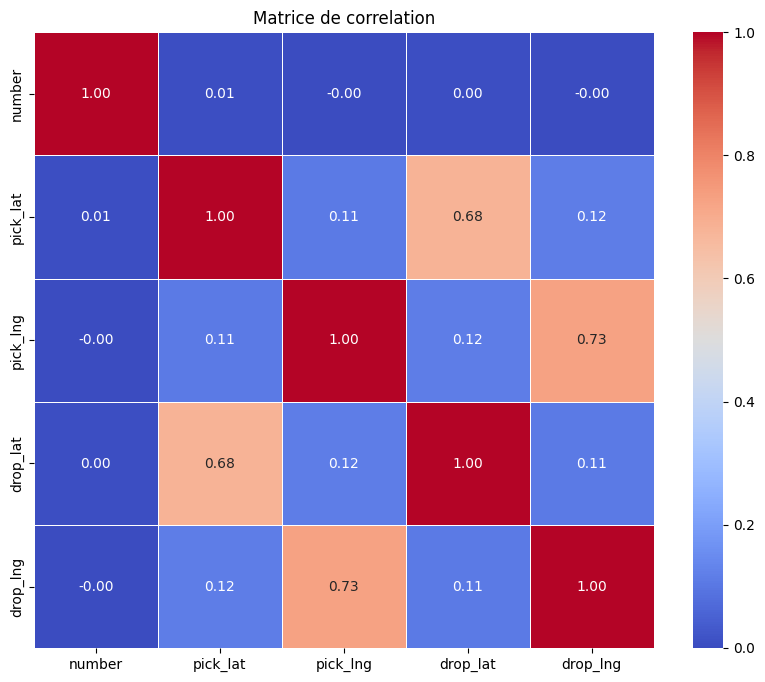

In [35]:
correlation_matrix = df.corr(numeric_only= True , method ='pearson')

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True , cmap = 'coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Matrice de correlation")
plt.show()

Nous observons une corrélation de 0.68 entre pick_lat et drop_lat :

Cela signifie que plus la latitude de départ (pick_lat) est élevée, plus la latitude de destination (drop_lat) a tendance à l’être également.

Nous observons également une corrélation de 0.73 entre pick_lng et drop_lng :

Cela suggère qu’une augmentation de la longitude de départ est fortement associée à une augmentation de la longitude d’arrivée, de manière quasi 
proportionnelle.

En revanche, la corrélation entre pick_lat et pick_lng est faible (0.11) :

Il n’y a donc pas de lien linéaire significatif entre la latitude et la longitude de départ.

De même, la corrélation entre pick_lat et drop_lng est également faible (0.12) :

Cela indique une relation négligeable entre la latitude de départ et la longitude d’arrivée.

In [ ]:
## Comme indiqué dans le libéllé nous allons passer au regroupement selon une zone particulière et à un moment donner afin de pouvoir mettre en place 
notre modèle de prediction .

In [ ]:
# Nous allons regroupé le nombre de trajet en fonction d'une zone et d'un temps donné .

In [38]:
df['pickup_hour'] = df['ts'].dt.hour

In [41]:
# Nous allons pour l'occasion créer un autre Data Frame

df_demand = df.groupby(['pickup_hour', 'pick_lat', 'pick_lng']) \
              .agg({'number': 'count'}) \
              .rename(columns={'number': 'nbre_de_course'}) \
              .reset_index()


In [51]:
df_demand.head()

,pickup_hour,pick_lat,pick_lng,nbre_de_course
0,0,12.834173,77.520050,618
1,0,12.834173,77.587440,1
2,0,12.834173,77.634370,1
3,0,12.834173,77.649080,19
4,0,12.834173,77.655525,2


In [50]:
df.head()

,ts,number,pick_lat,pick_lng,drop_lat,drop_lng,pickup_hour
0,2020-03-26 07:07:17,14626,12.834173,77.520050,12.831056,77.511210,7
1,2020-03-26 07:32:27,85490,12.943947,77.560745,12.954014,77.543770,7
2,2020-03-26 07:36:44,5408,12.899603,77.587300,12.934780,77.569950,7
3,2020-03-26 07:38:00,58940,12.918229,77.607544,12.968971,77.636375,7
4,2020-03-26 07:39:29,5408,12.899490,77.587270,12.934780,77.569950,7


In [ ]:
# Nous allons maintenant nous occuper des differentes restrictions 

In [59]:
# 1. Filtrer les demandes avec distance < 50 mètres (fraude)
from geopy.distance import geodesic

def calc_distance(row):
    pickup = (row['pick_lat'], row['pick_lng'])
    dropoff = (row['drop_lat'], row['drop_lng'])
    return geodesic(pickup, dropoff).meters

df['distance_m'] = df.apply(calc_distance, axis=1)

df = df[df['distance_m'] >= 50].copy()


In [61]:
# 2. Appliquons la regle de moins des 8 minutes après la première demande toutes zones confondues 

# Trier
df = df.sort_values('ts').reset_index(drop=True)

# Initialiser last_valid_time à une date un peu avant la plus ancienne date du df
last_valid_time = df['ts'].min() - pd.Timedelta(days=1)

valid_indices = []

for idx, current_time in enumerate(df['ts']):
    if (current_time - last_valid_time) >= pd.Timedelta(minutes=8):
        valid_indices.append(idx)
        last_valid_time = current_time

df_filtered = df.loc[valid_indices].reset_index(drop=True)


In [ ]:
# 3. Appliquons la regle de meme zone au cours d'une heure 

In [62]:
# Créer un identifiant de zone
df['zone'] = list(zip(df['pick_lat'], df['pick_lng']))

# Supprimer les doublons pour "même zone + même heure"
df_unique = df.drop_duplicates(subset=['zone', 'pickup_hour'])


In [64]:
df_unique.head()

,ts,number,pick_lat,pick_lng,drop_lat,drop_lng,pickup_hour,distance_m,zone
0,2020-03-26 01:23:31,35021,12.934723,77.615610,12.916122,77.61019,1,2140.229552,"(12.934723, 77.61561)"
1,2020-03-26 01:27:20,98185,12.962879,77.719140,12.930351,77.63338,1,9977.204702,"(12.962879, 77.71914)"
3,2020-03-26 01:27:29,90067,12.930832,77.612490,13.058285,77.68921,1,16373.394501,"(12.930832, 77.61249000000002)"
10,2020-03-26 01:28:11,90067,12.930996,77.612540,13.058285,77.68921,1,16355.012070,"(12.930996, 77.61254)"
11,2020-03-26 01:28:27,90067,12.930992,77.612526,13.058285,77.68921,1,16356.165587,"(12.930992, 77.612526)"


In [65]:
df = df_filtered
df = df_unique

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4183057 entries, 0 to 8362420
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   ts           datetime64[ns]
 1   number       int32         
 2   pick_lat     float64       
 3   pick_lng     float64       
 4   drop_lat     float64       
 5   drop_lng     float64       
 6   pickup_hour  int32         
 7   distance_m   float64       
 8   zone         object        
dtypes: datetime64[ns](1), float64(5), int32(2), object(1)
memory usage: 287.2+ MB
